# Comparison of machine learning methods applied to birdsong element classification 

## Introduction
This Jupyter notebook reproduces figures from a study that compares different machine learning algorithms applied to the classification of birdsong elements (in preparation). The manuscript provides more detail, but I outline the motivation here for context.

### Songbirds provide a model system for the study of learned vocalizations.
Like humans, songbirds learn to vocalize during a critical period in development. During that critical period, they require social interactions, sensory feedback, and practice to learn their vocalizations--again, just like humans. Songbirds have a network of brain areas dedicated to learning and producing their song, known as the song system. These brain areas occur only in songbirds, not in birds that do not learn their song. At the same time, the bird brain contains most of the major regions found in the human brain, and studies of songbirds have changed our understanding of certain brain areas, e.g., the basal ganglia. Because of these shared behaviors and brain areas, songbirds provide an excellent model system through which we can understand how the brain learns and produces motor skills like speech that are learned during a critical period in development.
### Machine-learning methods for labeling elements of song
Each bird’s song consists of repeated elements referred to as “syllables”:
<img src="./static/spect_birdsong.png" width=800px>
**Figure 1. Spectrogram of Bengalese finch song.** _Letters below the time axis, e..g, "i","a","b",..., are labels for syllables, discrete elements of song separated by brief silent intervals. Frequency (kHz) on the y axis and time on the x axis._

Each individual has a unique song which usually bears some similarity to the song of the bird that tutored it, but is not a direct copy. To analyze song, experimenters label syllables by hand. However, songbirds produce thousands of songs a day, more than can be labeled.

In order to deal with this mountain of data, some labs have developed automated analyses of birdsong. One popular approach scores songs based on similarity of spectrograms, without labeling syllables (Tchernichovski et al.,2000). Another method uses semi-automated clustering to label syllables, and then measures changes in acoustic and temporal structure of song over days using a distance metric (Wu, Thompson, et al., 2008). Other approaches make use of standard supervised learning algorithms to classify syllables, such as hidden Markov Models (Kogan and Margoliash, 1998). While code for some of these automated analyses is freely available, and there are some repositories of song on-line, to my knowledge almost no work has been done to compare the different methods.    

I set out to compare methods using one species, the Bengalese finch. This species is of interest for several reasons. For example, Bengalese finches depend heavily on auditory feedback throughout life to maintain their vocalizations, much like humans (Sober and Brainard, 2009, and references therein). In addition, their song tends to have relatively easy-to-quantify acoustic features (e.g., many of the syllables are "low entropy", having a pitchy, whistle-like timbre). Several previously-published studies or open-sourced libraries have applied various machine learning techniques to Bengalese finch song, including:  support vector machines (SVMs) (Tachibana et al. 2014), and k-Nearest Neighbors (kNNs) (http://www.utsa.edu/troyerlab/software.html). Again, no study has compared these methods with open-source code and freely shared data.

### Rationale
Here I compare the accuracy and amount of training data required for SVMs and kNNs. My criteria for the "best" algorithm is one which yields the highest accuracy across syllables, i.e., labels, and does so with the smallest amount of training data. To machine learning researchers, it might seem like a foregone conclusion that SVMs would perform better than kNNs, so let me explain why. My initial experiments sought to reproduce the results of Tachibana et al. 2014, using a linear SVM. I found impaired accuracy for some individual birds' songs. This led me to test methods that can yield non-linear decision boundaries, such as kNN, inspired by the Troyer lab's approach (http://www.utsa.edu/troyerlab/software.html). Ultimately, as I show below, I find that SVMs yield the highest accuracy with the least amount of training data, if a non-linear kernel is used, along with the features I found that improved accuracy.

## Results
### Set up notebook and load results

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%run load_results_linsvm_svmrbf_and_knn.py

## Intro syllables impair the accuracy of linear SVMs
In initial experiments, I applied the method of Tachibana et al. 2014 to song recorded from Bengalese Finches in our lab. Below I show that I was not able to reproduce their reported results, in spite of the fact that I used the exact same features and hyperparameters as Tachibana et al., 2014., and the same library for SVMs (LIBLINEAR, Fan et al. 2008). The black horizontal dashed line on the plots indicates their estimate of accuracy for a "large" data set, and the black vertical line indicates the average number of training samples they used to achieve this accuracy. An important difference between their experiments and mine is that I used actual hand-labeled data sets of the size typically needed for songbird studies, instead of using a smaller hand-labeled set and estimating the accuracy based on how well the smaller set was classified. 

Note that in all figures, the exact same training samples--originally drawn randomly from the training set--are used to train all classifiers.

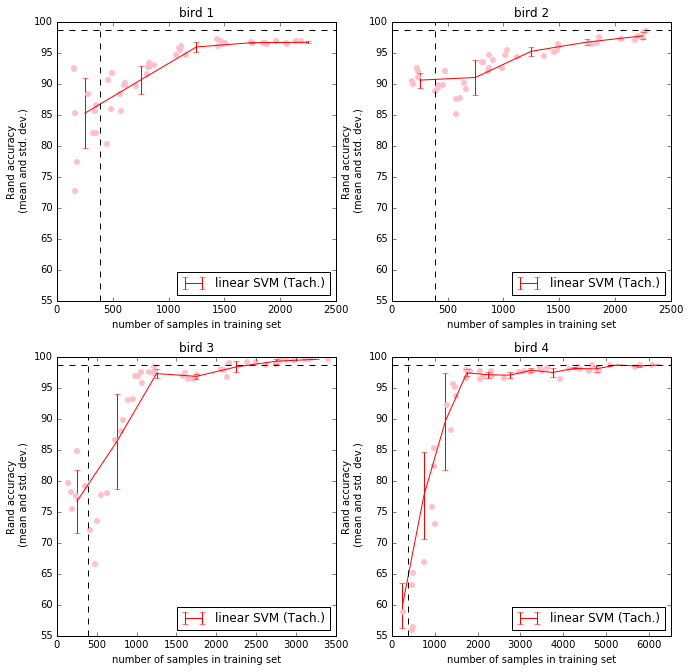

In [55]:
#below, estimate correct rate, from "Evaluation 3", fig.4, http://dx.doi.org/10.1371/journal.pone.0092584.g004
TACH_ACC = 98.7
#below, mean # samples for 1 minute training set, from Table 2, http://dx.doi.org/10.1371/journal.pone.0092584.t002
TACH_SAMPS = 387.5 
fig = plt.figure()
fig.set_size_inches(11,11)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
    bins_max = np.max(results['linsvm_train_sample_bins'])
    bin_centers = range(250,bins_max,500)
    plt.plot(results['num_train_samples_flat'],
             results['linsvm_test_rnd_acc_flat'],
             'o',color='pink',markeredgewidth=0)
    plt.errorbar(bin_centers,
                 results['linsvm_test_rnd_acc_by_sample_mn'],
                 yerr=results['linsvm_test_rnd_acc_by_sample_std'],
                 fmt='-r',label='linear SVM (Tach.)')
    plt.axhline(y=TACH_ACC,linestyle='--',c='k')
    plt.axvline(x=TACH_SAMPS,linestyle='--',c='k')
    plt.title(bird_name)
    plt.ylim((55,100))
    plt.xlim(xmax=bins_max)
    plt.xlabel('number of samples in training set')
    plt.ylabel('Rand accuracy\n (mean and std. dev.)')
    plt.legend(loc=4)
plt.savefig('linsvm_rand_acc_by_sample.png', bbox_inches='tight')

**Figure 2. Accuracy vs. number of songs used to train linear SVM.** _Y axis: Overall accuracy, x axis: number of samples in training set. Dashed horizontal line: average number of training samples used by Tachibana et al 2014. Vertical horizontal line: estimated accuracy using that number of samples._ Note that in no case is the red line near the vertical dashed line.

Below I show the same data in the way I will present results from now on, where the y axis is accuracy averaged across labels (i.e., syllable types), and the x axis is number of hand-labeled songs used to train the algorithm. I chose accuracy averaged across labels as a metric because the ideal case would be to have all syllables classified well, and the metric should take that into account. I chose the number of songs because typically researchers will label a number of songs instead of labeling e.g., "two minutes worth of syllables".  

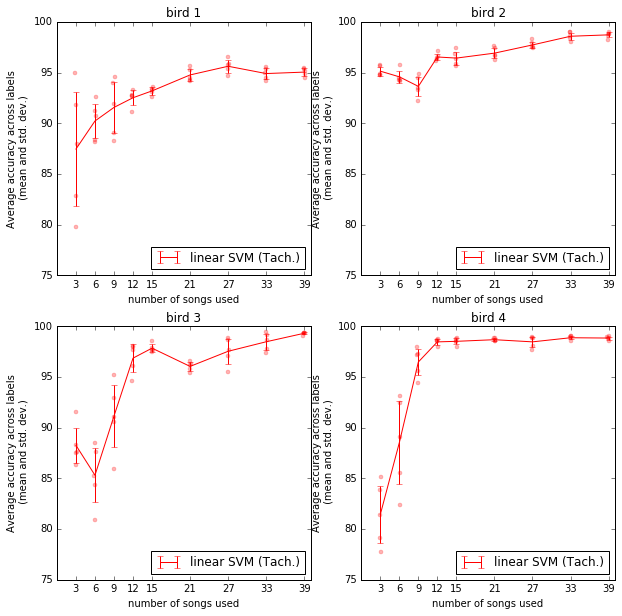

In [70]:
fig = plt.figure()
fig.set_size_inches(10,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['linsvm_test_avg_acc_mn'],
                 yerr=results['linsvm_test_avg_acc_std'],
                 fmt='-r',label='linear SVM (Tach.)')
    linsvm_avg_acc = np.asarray(results['linsvm_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'r.', alpha=0.3, markersize=8)
    plt.title(bird_name)
    plt.ylim((75,100))
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)
plt.savefig('linsvm_avg_acc_by_song.png', bbox_inches='tight')

**Figure 3. Accuracy vs. number of songs used to train linear SVM.** _Y axis: average accuracy across labels, x axis: number of songs used to train the linear SVM._ Note that accuracy is plotted as average accuracy across labels, and that this accuracy is unweighted, i.e., a syllable labeled with low accuracy drops the overall accuracy and does so proportional to the number of times it apears in the test set.

One possible reason for this impaired accuracy is the presence of “introductory notes”, low-amplitude noisy syllables that often occur at the start of song:
<img src="./static/spect_birdsong_intro_notes.png" width=600px>
**Figure 4. Introductory notes are low-amplitude noisy syllables that often occur at the start of song** _Red boxes indicate introductory notes._
For that reason I tested whether removing intro syllables (as I will refer to them from now on) from the training and test sets would rescue the accuracy of the linear SVM. In their initial experiments, Tachibana et al. 2014 removed intro syllables from song. 

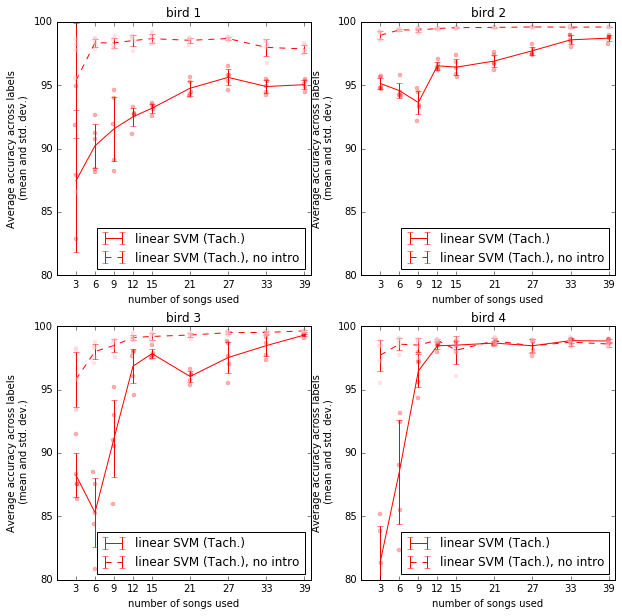

In [74]:
fig = plt.figure()
fig.set_size_inches(10,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
    plt.errorbar(NUM_SONGS_TO_TEST,results['linsvm_test_avg_acc_mn'],yerr=results['linsvm_test_avg_acc_std'],fmt='-r',label='linear SVM (Tach.)')
    linsvm_avg_acc = np.asarray(results['linsvm_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'r.', alpha=0.3, markersize=8)
    plt.errorbar(NUM_SONGS_TO_TEST,results['linsvm_test_no_intro_avg_acc_mn'],yerr=results['linsvm_test_no_intro_avg_acc_std'],fmt='--r',label='linear SVM (Tach.), no intro')
    linsvm_no_intro_avg_acc = np.asarray(results['linsvm_test_no_intro_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_no_intro_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, '.', alpha=0.4, markersize=8, color='pink')
    ax.set_ylim([80,100])
    plt.title(bird_name)
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)
plt.savefig('linsvm_avg_acc_without_intro.png', bbox_inches='tight')

**Figure 5. Accuracy vs. number of songs used to train linear SVM, with intro syllables removed from training and test sets.** _Y axis: average accuracy across labels, x axis: number of songs used to train the linear SVM._ Removing intro syllables greatly increased accuracy for three of four birds.

### k-Nearest Neighbors using domain-specific features produces high accuracy syllable classifcation
Because I could not achieve a high enough accuracy using linear SVM, I looked for other candidate algorithms, and found that the Troyer lab had previously described the use of k-nearest neighbors (k-NN) as I described above. The feature vectors I fed the k-NN algorithm contained acoustic parameters commonly measured for birdsong analyses, e.g., entropy, amplitude, pitch. My preliminary results using this approach did not yield the accuracy required. I improved accuracy by including in each feature vector the durations of preceding and following syllables and silent gaps that separate syllables.
<img src="./static/features.png" width=600px>
**Figure 6. Duration features of preceding and following syllables and silent gaps that were added to the vector of features representing each syllable.**

Addition of these features was sufficient to achieve classification accuracy better than the linear SVM with less training samples for three of the four birds.

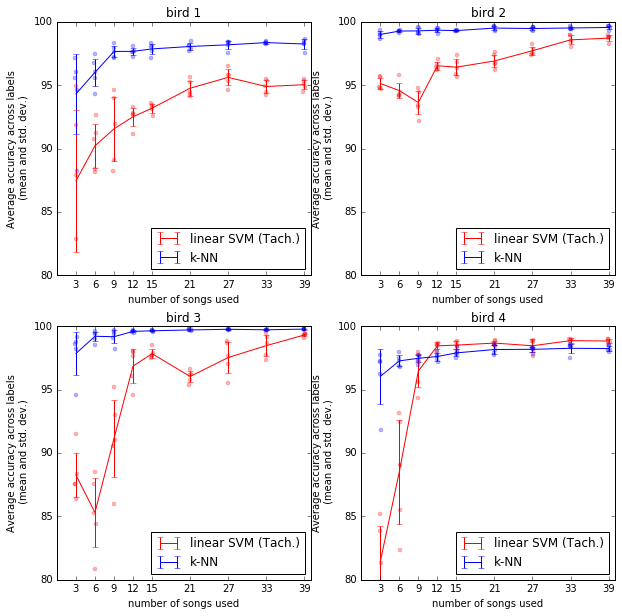

In [77]:
fig = plt.figure()
fig.set_size_inches(10,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
    plt.errorbar(NUM_SONGS_TO_TEST,results['linsvm_test_avg_acc_mn'],yerr=results['linsvm_test_avg_acc_std'],fmt='-r',label='linear SVM (Tach.)')
    linsvm_avg_acc = np.asarray(results['linsvm_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'r.', alpha=0.3, markersize=8)
    plt.errorbar(NUM_SONGS_TO_TEST,results['knn_test_avg_acc_mn'],yerr=results['knn_test_avg_acc_std'],fmt='-b',label='k-NN')
    knn_avg_acc = np.asarray(results['knn_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = knn_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'b.', alpha=0.3, markersize=8)
    ax.set_ylim([80,100])
    plt.title(bird_name)
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)
plt.savefig('linsvm_v_knn_avg_acc_by_song.png', bbox_inches='tight')

**Figure 7. Accuracy v. number of songs used to train linear SVM and k-NN algorithms** _Y axis: average accuracy across labels, x axis: number of songs used to train._ In three out of four cases, k-NN yields higher accuracy than linear SVM, and in every case, k-NN yielded higher accuracy with less training data, although linear SVM outperformed k-NN for bird 4 given 15 songs or more.

### Use of a radial basis function (RBF) rescues SVM accuracy
Results of the previous experiments suggest that accurate syllable classification requires a non-linear decision boundary, like those provided by k-NN, probably because of the variability in intro syllables. Commonly, the radial basis function (RBF) is used as a non-linear kernel with SVMs to deal with such situations. I again used the same features that Tachibana et al. 2014 used, but replaced the linear SVM with an SVM using an RBF. Hyperparameters for the RBF ('C' and 'gamma') were found for each subset of training samples using grid search.

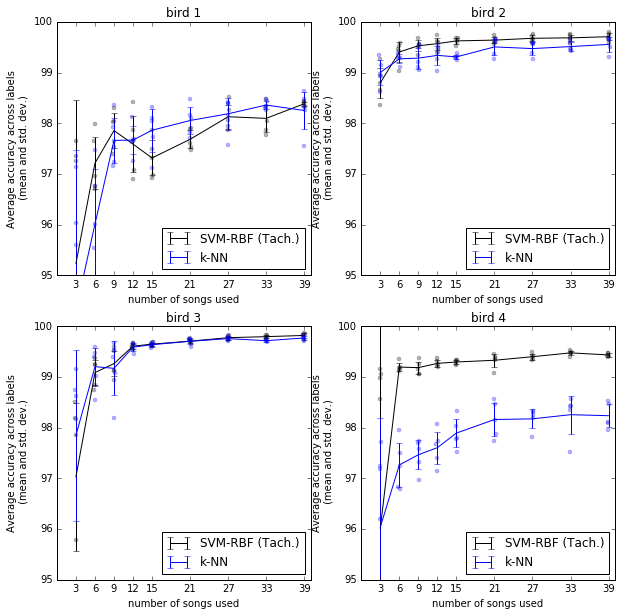

In [82]:
fig = plt.figure()
fig.set_size_inches(10,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
    plt.errorbar(NUM_SONGS_TO_TEST,results['svm_Tach_test_avg_acc_mn'],yerr=results['svm_Tach_test_avg_acc_std'],fmt='-k',label='SVM-RBF (Tach.)')
    svm_Tach_avg_acc = np.asarray(results['svm_Tach_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = svm_Tach_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'k.', alpha=0.3, markersize=8)
    plt.errorbar(NUM_SONGS_TO_TEST,results['knn_test_avg_acc_mn'],yerr=results['knn_test_avg_acc_std'],fmt='-b',label='k-NN')
    knn_avg_acc = np.asarray(results['knn_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = knn_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'b.', alpha=0.3, markersize=8)
    ax.set_ylim([95,100])
    plt.title(bird_name)
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)
plt.show()
plt.savefig('svmrbf_v_knn_avg_acc_by_song.png', bbox_inches='tight')

**Figure 8. Accuracy v. number of songs used to train k-NN and SVM-RBF algorithms** _Y axis: average accuracy across labels, x axis: number of songs used to train._ SVM-RBF performs better than k-NN for two of the four birds, and for three of the four birds achieves higher than 99% accuracy.

### Addition of duration features from preceding and following syllables and silent gaps further improves SVM-RBF accuracy
If features from preceding and following syllables improve k-NN performance, they might improve the SVM-RBF performance as well. I also tested this.

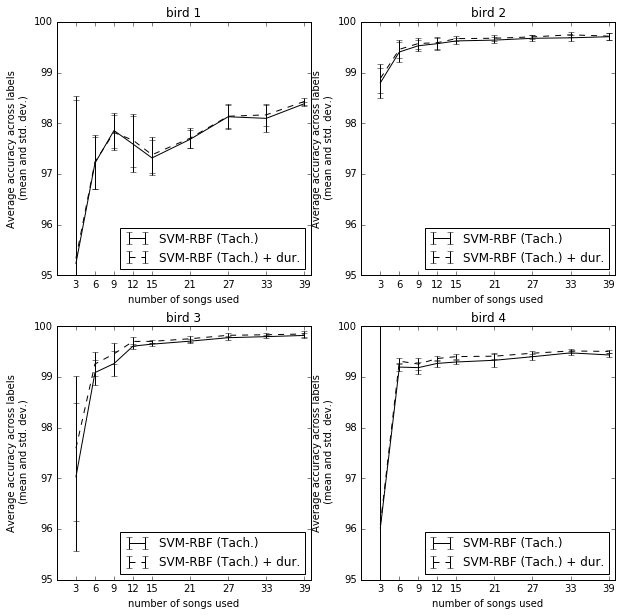

In [81]:
fig = plt.figure()
fig.set_size_inches(10,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['svm_Tach_test_avg_acc_mn'],
                 yerr=results['svm_Tach_test_avg_acc_std'],
                 fmt='-k',label='SVM-RBF (Tach.)')
    svm_Tach_avg_acc = np.asarray(results['svm_Tach_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = svm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'k.', alpha=0.3, markersize=8)
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['svm_test_avg_acc_mn'],
                 yerr=results['svm_test_avg_acc_std'],
                 fmt='--k',label='SVM-RBF (Tach.) + dur.')
    svm_Tach_avg_acc = np.asarray(results['svm_Tach_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = svm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'k.', alpha=0.3, markersize=8)
    ax.set_ylim([95,100])
    plt.title(bird_name)
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)
plt.savefig('svmrbf_plus_dur_avg_acc_by_song.png', bbox_inches='tight')

**Figure 9. Accuracy v. number of songs used to train SVM-RBF and SVM-RBF with duration features added** _Y axis: average accuracy across labels, x axis: number of songs used to train._ In all cases, the added duration features yielded a higher accuracy.

## Conclusion
The results suggest SVM-RBF provides the highest accuracy across different birds' songs. For three of four birds, labeling as few as fifteen songs by hand provides enough training data to achieve greater than 99.2% average accuracy with SVM-RBF. This is approximately 40 seconds of song (assuming 50 milliseconds per syllable and 50 syllables per song), in comparison to previous papers that reported using a minute of song to achieve such accuracies.
The success of SVM-RBF is likely because the kernel allows for non-linear decision boundaries that can separate more variable types of syllables, such as the low-amplitude, high entropy "intro" syllables.
Further experiments should determine how well these algorithms deal with the presence of sounds that are not part of song, e.g., calls, movement of the bird on its perch, etc. Such experiments are necessary to further reduce the amount of work required on the part of the experimenter. I expect that the SVM-RBF will succeed in the face of these non-songbird elements as well. As the results above demonstrate, it is important to actually test how the algorithms compare with each other on varied data sets, and to present the results and code used to obtain those results in as accessible a manner as possible.

## Supplementary figures

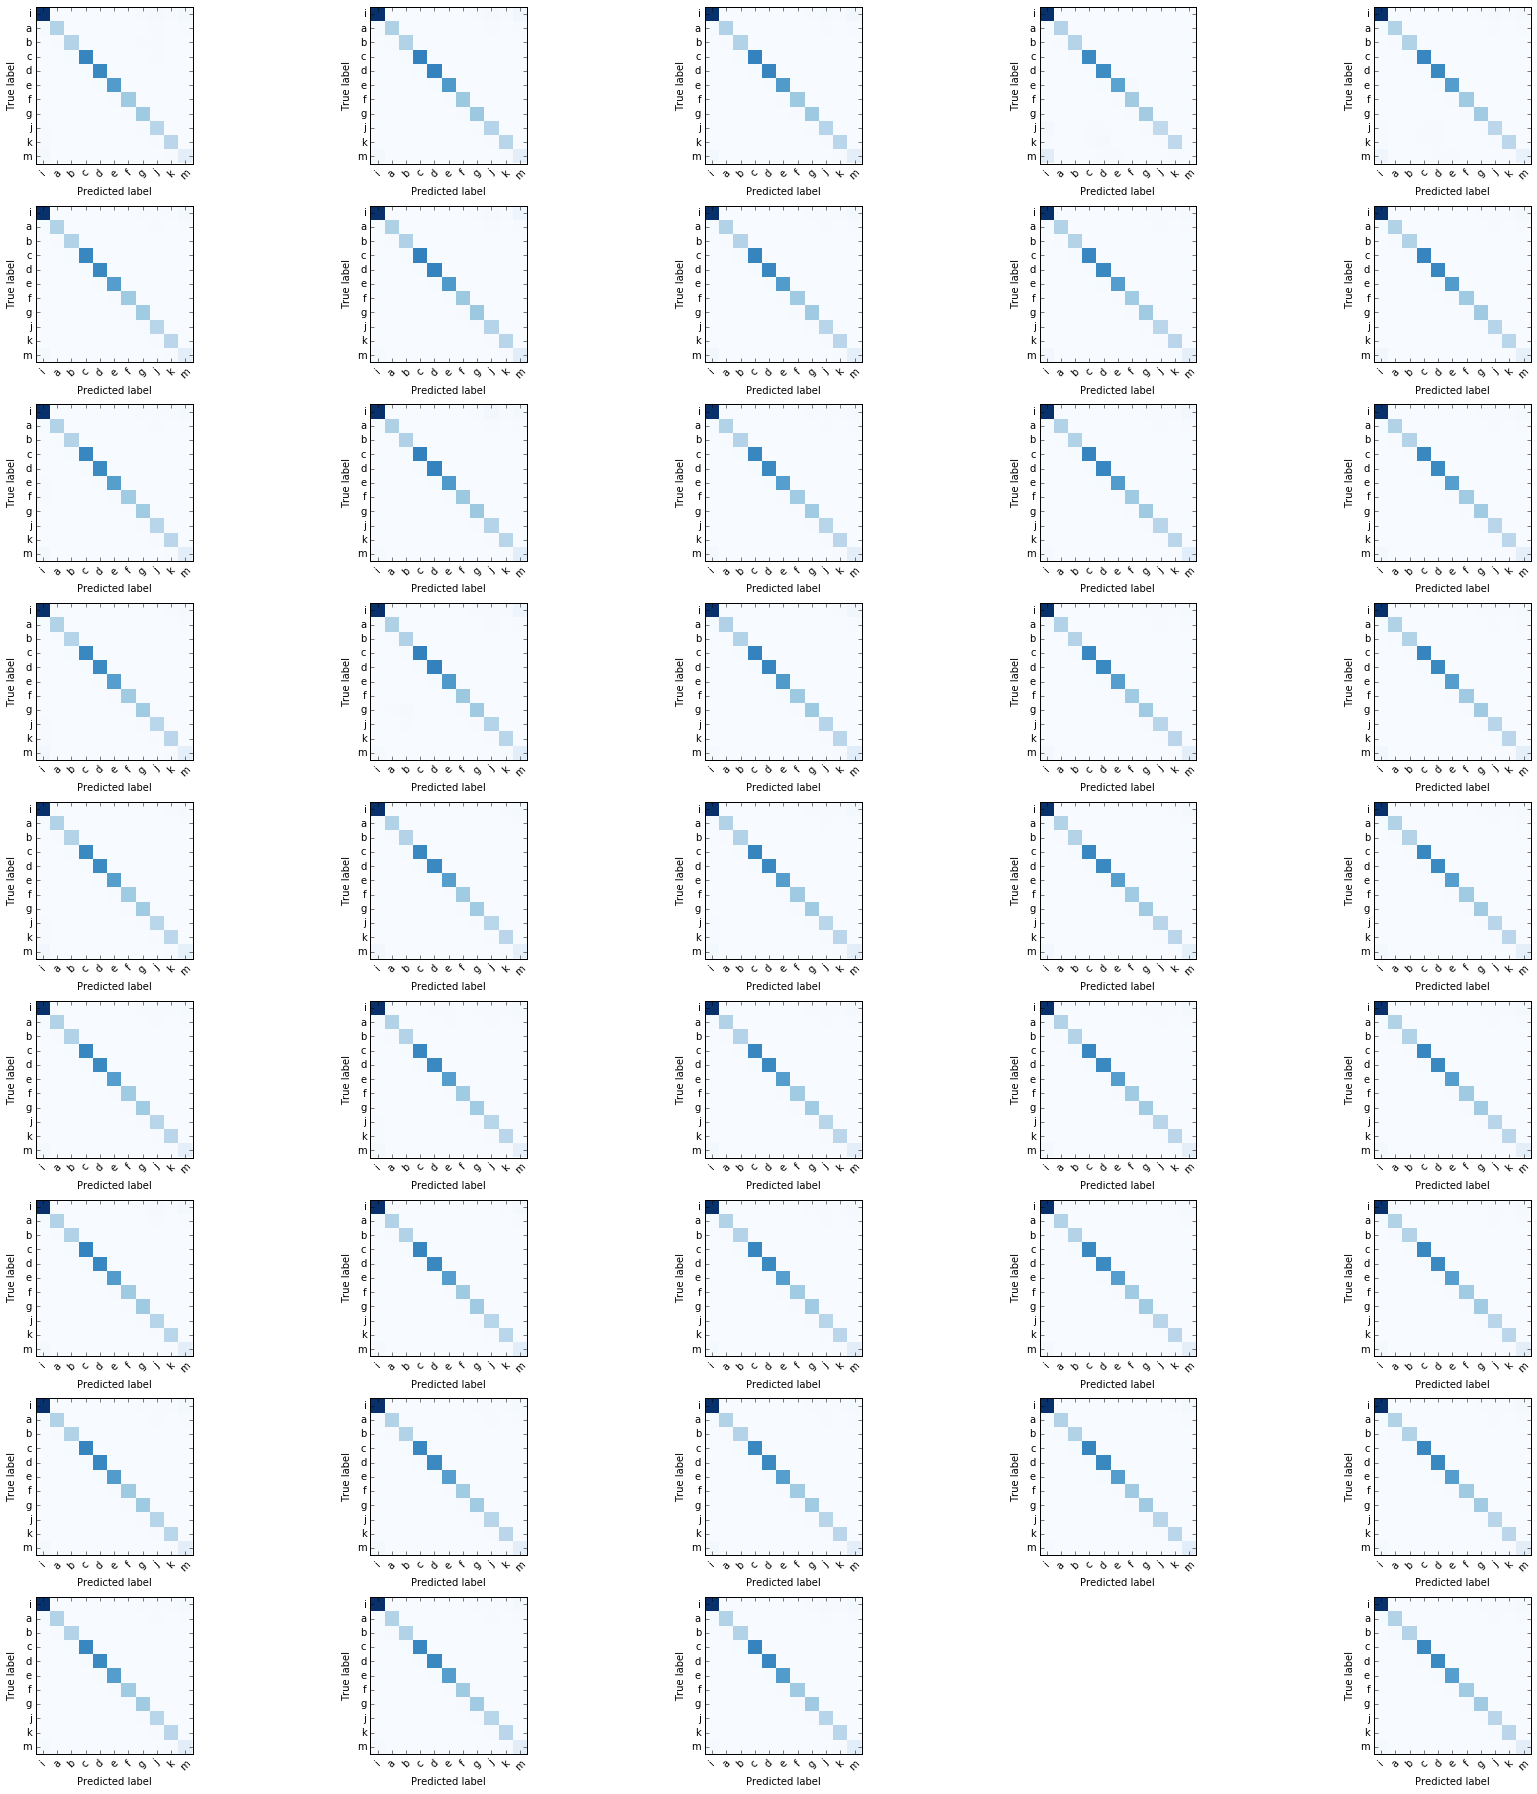

In [8]:
# bird 1 confusion matrices
svm_cm_arr_gr41rd51 = results_dict['gr41rd51']['svm_test_cm_arr']
labelset_gr41rd51 = [chr(char) for char in results_dict['gr41rd51']['labelset']]fig = plt.figure()
fig.set_size_inches(25,25)
for row in range(0,9):
    for col in range(0,5):
        cm = np.asarray(svm_cm_arr_gr41rd51[col][row])
        cm_norml = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        pos = (row * 5) + col + 1
        ax = plt.subplot(9, 5, pos)
        plt.imshow(cm, interpolation='none', cmap=plt.cm.Blues)
        plt.tight_layout()
        tick_marks = np.arange(len(labelset_gr41rd51))
        plt.xticks(tick_marks, labelset_gr41rd51, rotation=45)
        plt.yticks(tick_marks, labelset_gr41rd51)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

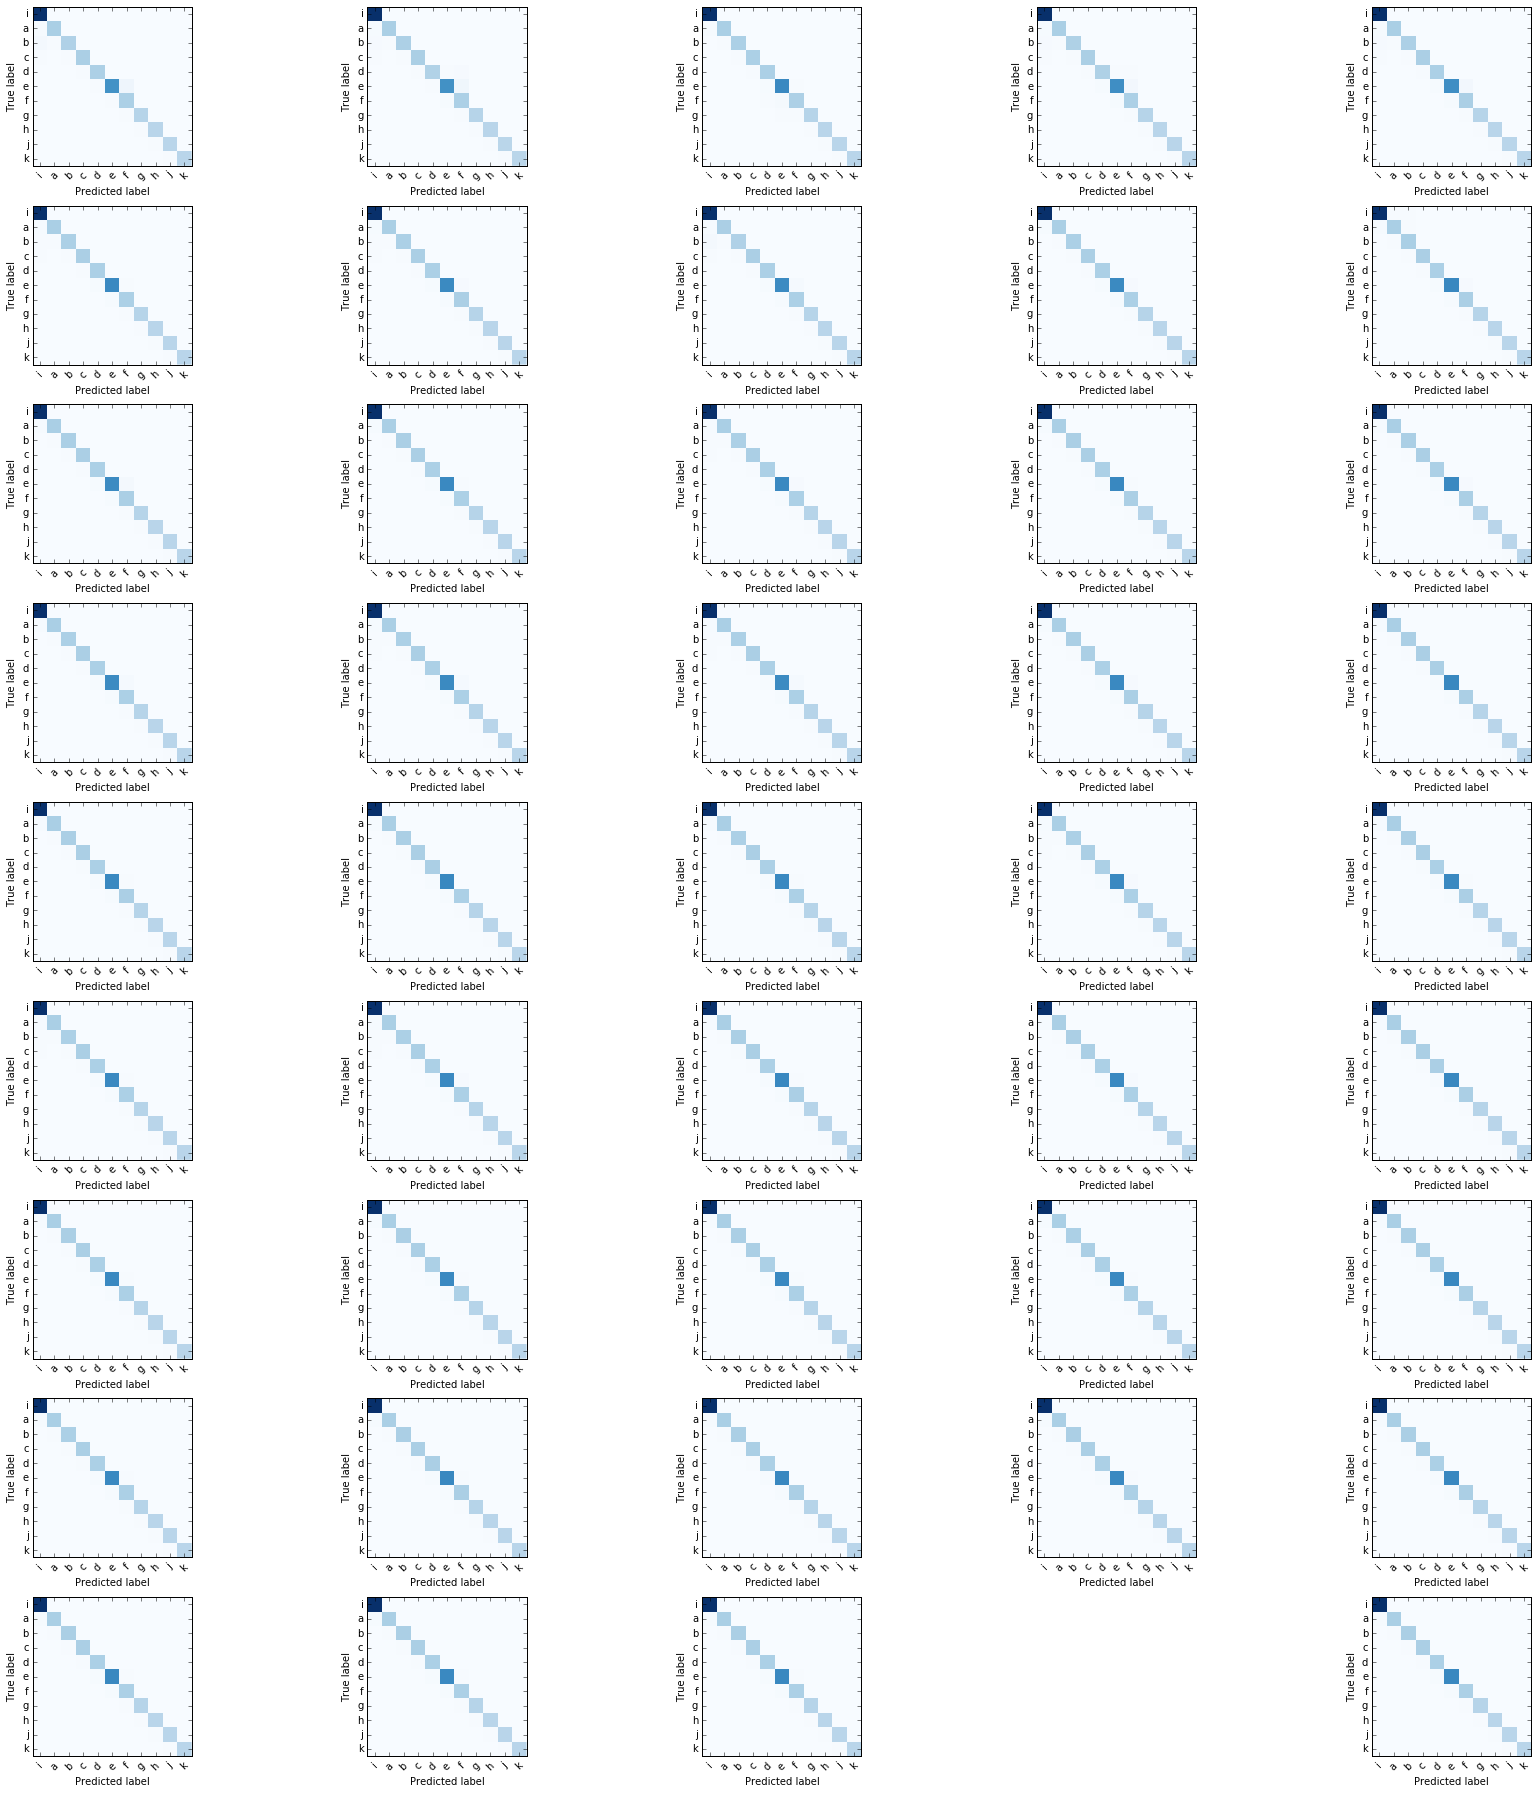

In [10]:
# bird 2 confusion matrices
svm_cm_arr_gy6or6 = results_dict['gy6or6']['svm_test_cm_arr']
labelset_gy6or6 = [chr(char) for char in results_dict['gy6or6']['labelset']]
fig = plt.figure()
fig.set_size_inches(25,25)
for row in range(0,9):
    for col in range(0,5):
        cm = np.asarray(svm_cm_arr_gy6or6[col][row])
        cm_norml = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        pos = (row * 5) + col + 1
        ax = plt.subplot(9, 5, pos)
        plt.imshow(cm, interpolation='none', cmap=plt.cm.Blues)
        plt.tight_layout()
        tick_marks = np.arange(len(labelset_gy6or6))
        plt.xticks(tick_marks, labelset_gy6or6, rotation=45)
        plt.yticks(tick_marks, labelset_gy6or6)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')